In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

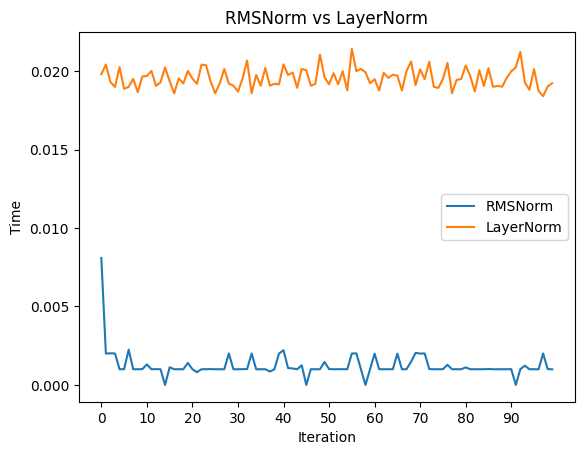

In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, dim:int, eps:float=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    
    def _norm(self, x:torch.Tensor):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        # d + d  + d

    def forward(self, x: torch.Tensor):
        return self.weight * self._norm(x.float()).type_as(x)
        # d
    
class LayerNorm(nn.Module):
    def __init__(self, dim:int, eps:float=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
        self.bias = nn.Parameter(torch.zeros(dim))
    
    def forward(self, x:torch.Tensor):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.weight * (x - mean) / (std + self.eps) + self.bias
    # d + (d + d + d) + (d + d + d)

## compare time
import time
import numpy as np
import matplotlib.pyplot as plt

x = torch.randn(1024, 1024) # 1024개 데이터 1024개 숫자
rmsnorm = RMSNorm(1024) # 1024차원
layernorm = LayerNorm(1024) # 1024차원

rmsnorm_time = []
layernorm_time = []

for i in range(100):
    start = time.time()
    rmsnorm(x)
    rmsnorm_time.append(time.time() - start)
    
    start = time.time()
    layernorm(x)
    layernorm_time.append(time.time() - start)

plt.plot(np.arange(100), rmsnorm_time, label='RMSNorm')
plt.plot(np.arange(100), layernorm_time, label='LayerNorm')
plt.xticks(np.arange(0, 100, 10))
plt.xlabel('Iteration')
plt.ylabel('Time')
plt.title('RMSNorm vs LayerNorm')
plt.legend()
plt.show()


Dim: 256, RMSNorm: 0.000601s, LayerNorm: 0.004950s
Dim: 512, RMSNorm: 0.000653s, LayerNorm: 0.009698s
Dim: 768, RMSNorm: 0.001101s, LayerNorm: 0.014484s
Dim: 1024, RMSNorm: 0.001803s, LayerNorm: 0.019660s
Dim: 1280, RMSNorm: 0.002247s, LayerNorm: 0.024496s
Dim: 1536, RMSNorm: 0.002292s, LayerNorm: 0.029633s
Dim: 1792, RMSNorm: 0.002902s, LayerNorm: 0.035307s
Dim: 2048, RMSNorm: 0.002929s, LayerNorm: 0.039943s


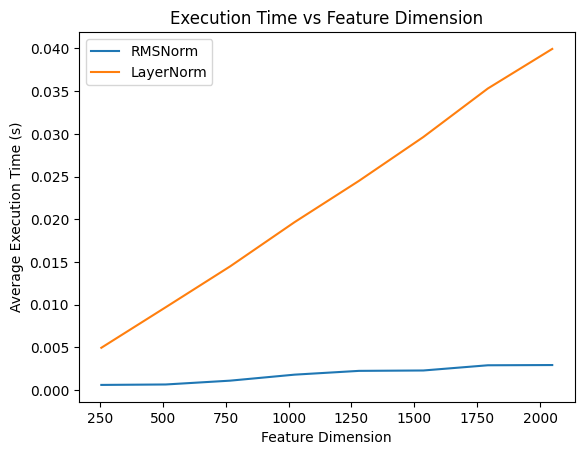

In [19]:

# 비교를 위한 설정: feature dimension을 변화시키면서 실행 시간 측정
feature_dims = np.arange(256, 2049, 256)  # 256, 512, ..., 2048
batch_size = 1024
num_iterations = 10  # 각 설정에 대해 반복 횟수

times_rmsnorm = []
times_layernorm = []

for dim in feature_dims:
    # 입력 데이터 생성
    x = torch.randn(batch_size, dim)
    
    # 각 정규화 레이어 생성
    rmsnorm = RMSNorm(dim)
    layernorm = LayerNorm(dim)
    
    # 워밍업 (최초 오버헤드 제거)
    for _ in range(3):
        _ = rmsnorm(x)
        _ = layernorm(x)
    
    # 실행 시간 측정
    t_rms = 0.0
    t_layer = 0.0
    for _ in range(num_iterations):
        start = time.time()
        _ = rmsnorm(x)
        t_rms += time.time() - start

        start = time.time()
        _ = layernorm(x)
        t_layer += time.time() - start
    
    avg_t_rms = t_rms / num_iterations
    avg_t_layer = t_layer / num_iterations
    
    times_rmsnorm.append(avg_t_rms)
    times_layernorm.append(avg_t_layer)
    print(f"Dim: {dim}, RMSNorm: {avg_t_rms:.6f}s, LayerNorm: {avg_t_layer:.6f}s")

# 결과 플롯 그리기
plt.plot(feature_dims, times_rmsnorm, label='RMSNorm')
plt.plot(feature_dims, times_layernorm, label='LayerNorm')
plt.xlabel('Feature Dimension')
plt.ylabel('Average Execution Time (s)')
plt.title('Execution Time vs Feature Dimension')
plt.legend()
plt.show()

Dim: 1024, Seq Length: 64, RMSNorm: 0.003403s, LayerNorm: 0.040951s
Dim: 1024, Seq Length: 128, RMSNorm: 0.007454s, LayerNorm: 0.082446s
Dim: 1024, Seq Length: 192, RMSNorm: 0.010674s, LayerNorm: 0.124184s
Dim: 1024, Seq Length: 256, RMSNorm: 0.015225s, LayerNorm: 0.167640s
Dim: 1024, Seq Length: 320, RMSNorm: 0.017603s, LayerNorm: 0.208213s
Dim: 1024, Seq Length: 384, RMSNorm: 0.021426s, LayerNorm: 0.250600s
Dim: 1024, Seq Length: 448, RMSNorm: 0.025416s, LayerNorm: 0.294085s
Dim: 1024, Seq Length: 512, RMSNorm: 0.029716s, LayerNorm: 0.336634s
Dim: 1024, Seq Length: 576, RMSNorm: 0.032391s, LayerNorm: 0.385599s
Dim: 1024, Seq Length: 640, RMSNorm: 0.036003s, LayerNorm: 0.427095s
Dim: 1024, Seq Length: 704, RMSNorm: 0.040038s, LayerNorm: 0.472083s
Dim: 1024, Seq Length: 768, RMSNorm: 0.042804s, LayerNorm: 0.510881s
Dim: 1024, Seq Length: 832, RMSNorm: 0.049212s, LayerNorm: 0.541935s
Dim: 1024, Seq Length: 896, RMSNorm: 0.050791s, LayerNorm: 0.586606s
Dim: 1024, Seq Length: 960, RMSNorm

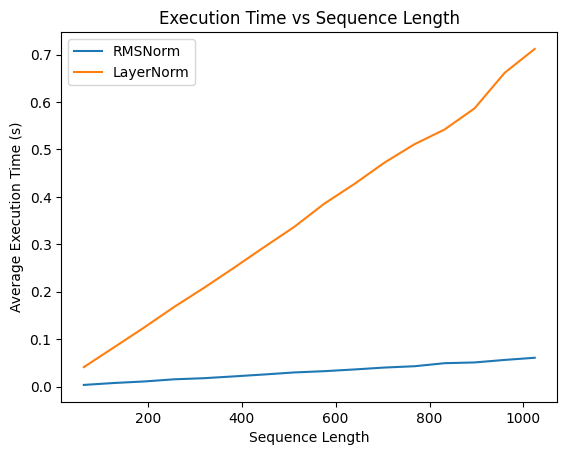

In [ ]:
import torch
import torch.nn as nn
import time
import numpy as np
import matplotlib.pyplot as plt

# 비교를 위한 설정: 시퀀스 길이를 변화시키면서 실행 시간 측정
sequence_lengths = np.arange(64, 1025, 64)  # 예: 64, 128, ..., 1024
batch_size = 32
feature_dim = 1024  # 고정
num_iterations = 10  # 각 설정에 대해 반복 횟수

times_rmsnorm = []
times_layernorm = []

for seq_len in sequence_lengths:
    # 입력 데이터 생성: (batch_size, sequence_length, feature_dim)
    x = torch.randn(batch_size, seq_len, feature_dim)
    
    # 정규화 레이어 생성 (feature_dim에 맞게)
    rmsnorm = RMSNorm(feature_dim)
    layernorm = LayerNorm(feature_dim)
    
    # 워밍업: 초기 오버헤드 제거
    for _ in range(3):
        _ = rmsnorm(x)
        _ = layernorm(x)
    
    # 실행 시간 측정
    t_rms = 0.0
    t_layer = 0.0
    for _ in range(num_iterations):
        start = time.time()
        _ = rmsnorm(x)
        t_rms += time.time() - start

        start = time.time()
        _ = layernorm(x)
        t_layer += time.time() - start
    
    avg_t_rms = t_rms / num_iterations
    avg_t_layer = t_layer / num_iterations
    
    times_rmsnorm.append(avg_t_rms)
    times_layernorm.append(avg_t_layer)
    print(f"Dim: {feature_dim}, Seq Length: {seq_len}, RMSNorm: {avg_t_rms:.6f}s, LayerNorm: {avg_t_layer:.6f}s")

# 결과 플롯 그리기
plt.plot(sequence_lengths, times_rmsnorm, label='RMSNorm')
plt.plot(sequence_lengths, times_layernorm, label='LayerNorm')
plt.xlabel('Sequence Length')
plt.ylabel('Average Execution Time (s)')
plt.title('Execution Time vs Sequence Length')
plt.legend()
plt.show()
